In [1]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import libraries

import numpy as np 
import pandas as pd
import sklearn.cluster as cluster
import seaborn as sns
import matplotlib.pyplot as plt
import umap

from google.colab import files
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
from sklearn.decomposition import PCA

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, Isomap, MDS

In [3]:
# Three different ways to calculate initial centroids 

def maximize_distance_centroids(ds, k, random_state=42):    
    np.random.seed(random_state)
    centroids = []
    ks = np.shape(ds)[0]
    r = np.random.randint(0, ks)
    centroids.append(ds[r])
    seen_r = list()
    seen_r.append(r)
    dist_mat = euclidean_distances(ds, centroids)
    centroids.append(ds[np.argmax(dist_mat)])
    seen_r.append(np.argmax(dist_mat))
    while(k > 2):
      dist_mat = euclidean_distances(ds, centroids)
      min_dist = 100
      min_idx = 0
      for idx, x in enumerate(dist_mat):
        total = sum(x) / len(centroids)
        min_diff = sum(abs(x - total))
        if min_diff < min_dist and idx not in seen_r:
          min_idx = idx
          min_dist = min_diff
      centroids.append(ds[min_idx])
      seen_r.append(min_idx)
      k-=1
    return np.array(centroids)

def best_sse_centroids(ds, k, random_state=42):    
    np.random.seed(random_state)
    centroids = []
    sse_i=np.zeros(k)
    ks = np.shape(ds)[0]
    prev_sse = float('inf')
    itr = 0
    while(itr < 100):
      itr+=1
      temp_centroids = []
      for i in range(k):
          r = np.random.randint(0, ks)
          temp_centroids.append(ds[r])

      distances = euclidean_distances(ds, temp_centroids)
      clusters = np.argmin(distances, axis = 1)
      
      for i in range(k):
        sse_i[i] = np.sum((ds[clusters == i]-ds[r])**2)
      
      sse = sum(sse_i)
      
      if sse < prev_sse:
        centroids = temp_centroids.copy()
        prev_sse = sse

    return np.array(centroids)

def random_centroids(ds, k, random_state=42):    
    np.random.seed(random_state)
    centroids = []
    ks = np.shape(ds)[0]
    for i in range(k):
        r = np.random.randint(0, ks)
        centroids.append(ds[r])

    return np.array(centroids)

In [4]:
def calculate_distance(X, centroids, dist='euclidian'):
    if dist =='cosine':
        return cosine_distances(X, centroids)
    elif dist =='manhattan':
        return manhattan_distances(X, centroids)
    else:
        return euclidean_distances(X, centroids)
    

def kmeans(X,k,dist='euclidian', centroid_metric='best_sse', max_itr=500):
    if centroid_metric == 'maximize':
      initial_centroids = maximize_distance_centroids(X, k)
    elif centroid_metric == 'best_sse':
      initial_centroids = best_sse_centroids(X, k)
    else:
      initial_centroids = random_centroids(X, k)
    
    centroids_old = np.zeros(initial_centroids.shape)
    centroids_new = initial_centroids.copy()
    clusters = np.zeros(X.shape[0])
    distances = np.zeros((X.shape[0],k))
    sse_i=np.zeros(k)
    error = np.linalg.norm(centroids_new - centroids_old)
    itr = 0
    while error != 0 or itr > max_itr:
        itr+=1
        distances = calculate_distance(X, centroids_new, dist=dist)
        clusters = np.argmin(distances, axis = 1)
        centroids_old = centroids_new.copy()
        for i in range(k):
            if not np.any(X[clusters == i]):
              continue
            centroids_new[i] = np.mean(X[clusters == i], axis=0)
            if np.isnan(centroids_new[i]).any()==True:
                centroids_new[i] = centroids_old[i]
            sse_i[i] = np.sum((X[clusters == i]-centroids_new[i])**2)
        error = np.linalg.norm(centroids_new - centroids_old)
    sse = sum(sse_i)
    print(f"Number of iteration took to converge with {centroid_metric} metric: {itr}")
    print(f"Sum of Squared Error for the final centroids: {sse}")
    return clusters, sse

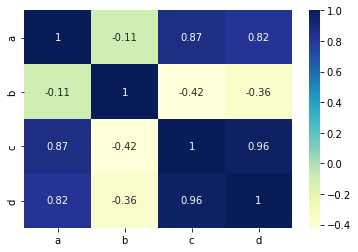

In [5]:
def see_correlation(train_df):
  train_df.corr()
  sns.heatmap(train_df.corr(), cmap="YlGnBu", annot=True)
  plt.show()

def irish_data_correlation():
  train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668786396_6504366_test-data-iris.txt'
  train_df = pd.read_csv(train_data_url, header=None, names=['a', 'b', 'c', 'd'], sep=' ')
  see_correlation(train_df)

irish_data_correlation()

In [6]:
def irish_cluster_final_prediction():
  train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668786396_6504366_test-data-iris.txt'
  train_df = pd.read_csv(train_data_url, header=None, names=['a', 'b', 'c', 'd'], sep=' ')
  train_df.drop(['a', 'b'], axis=1, inplace=True)
  X = train_df.values
  X = PCA(n_components=1).fit_transform(X)
  clusters, sse = kmeans(X,3,dist='euclidian', centroid_metric='best_sse')
  df = pd.DataFrame(clusters)
  df.to_csv('irish_prediction.csv', index=False, header=False) 
  files.download("irish_prediction.csv")

irish_cluster_final_prediction()

Number of iteration took to converge with best_sse metric: 15
Sum of Squared Error for the final centroids: 26.40625800704791


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of iteration took to converge with best_sse metric: 34
Sum of Squared Error for the final centroids: 16094.011901855469


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

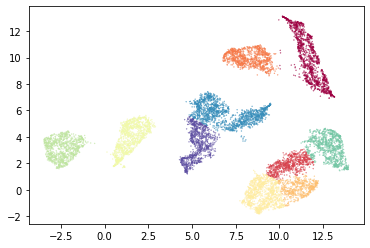

In [7]:
def image_cluster_final_prediction():
  train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668784614_268637_test-data-images.txt'
  train_df = pd.read_csv(train_data_url, header=None, sep=',')
  k = 10
  X = train_df.values
  reducer = umap.UMAP(random_state=42, n_components=2)
  X = reducer.fit_transform(X)
  clusters, sse = kmeans(X,10,dist='euclidian', centroid_metric='best_sse')
  plt.scatter(X[:, 0], X[:, 1], c=clusters+1, s=0.1, cmap='Spectral');
  df = pd.DataFrame(clusters+1)
  df.to_csv('image_prediction.csv', index=False, header=False) 
  files.download("image_prediction.csv")

image_cluster_final_prediction()

Number of iteration took to converge with best_sse metric: 28
Sum of Squared Error for the final centroids: 191836.5234375
Number of iteration took to converge with best_sse metric: 8
Sum of Squared Error for the final centroids: 52488.7236328125
Number of iteration took to converge with best_sse metric: 34
Sum of Squared Error for the final centroids: 31759.634826660156
Number of iteration took to converge with best_sse metric: 12
Sum of Squared Error for the final centroids: 19715.19403076172
Number of iteration took to converge with best_sse metric: 34
Sum of Squared Error for the final centroids: 16094.011901855469
Number of iteration took to converge with best_sse metric: 28
Sum of Squared Error for the final centroids: 12268.635452270508
Number of iteration took to converge with best_sse metric: 29
Sum of Squared Error for the final centroids: 9203.759292602539
Number of iteration took to converge with best_sse metric: 31
Sum of Squared Error for the final centroids: 7213.9216156

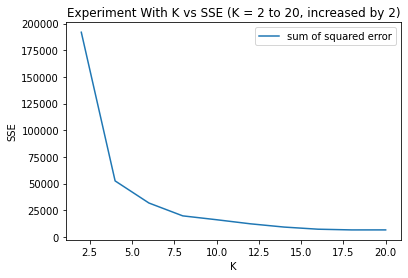

In [8]:
def experiment_k_vs_sse():
  train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668784614_268637_test-data-images.txt'
  train_df = pd.read_csv(train_data_url, header=None, sep=',')
  k_array = list()
  X = train_df.values
  reducer = umap.UMAP(random_state=42, n_components=2)
  X = reducer.fit_transform(X)
  y = list()

  for k in range(2,21,2):
    clusters, sse = kmeans(X,k=k,dist='euclidian', centroid_metric='best_sse')
    y.append(sse)
    k_array.append(k)
  
  plt.plot(k_array, y, label = "sum of squared error")
  plt.ylabel('SSE')
  plt.xlabel('K')
  plt.title('Experiment With K vs SSE (K = 2 to 20, increased by 2)')
  plt.legend()
  plt.show()

experiment_k_vs_sse()

Number of iteration took to converge with best_sse metric: 5
Sum of Squared Error for the final centroids: 81.02454100442398
Number of iteration took to converge with best_sse metric: 15
Sum of Squared Error for the final centroids: 26.40625800704791
Number of iteration took to converge with best_sse metric: 10
Sum of Squared Error for the final centroids: 14.261829507667803
Number of iteration took to converge with best_sse metric: 8
Sum of Squared Error for the final centroids: 9.328146895610896
Number of iteration took to converge with best_sse metric: 14
Sum of Squared Error for the final centroids: 7.596811930946133
Number of iteration took to converge with best_sse metric: 12
Sum of Squared Error for the final centroids: 6.9329722328232455
Number of iteration took to converge with best_sse metric: 10
Sum of Squared Error for the final centroids: 4.969340373463751
Number of iteration took to converge with best_sse metric: 13
Sum of Squared Error for the final centroids: 6.34724364

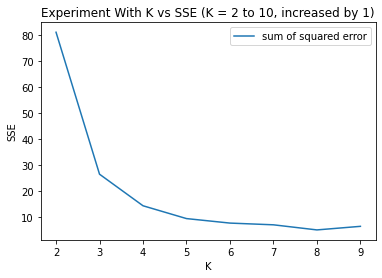

In [10]:
def experiment_k_vs_sse_iris():
  train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668786396_6504366_test-data-iris.txt'
  train_df = pd.read_csv(train_data_url, header=None, names=['a', 'b', 'c', 'd'], sep=' ')
  train_df.drop(['a', 'b'], axis=1, inplace=True)
  X = train_df.values
  X = PCA(n_components=1).fit_transform(X)
  y = list()
  k_array = list()

  for k in range(2,10,1):
    clusters, sse = kmeans(X,k=k,dist='euclidian', centroid_metric='best_sse')
    y.append(sse)
    k_array.append(k)
  
  plt.plot(k_array, y, label = "sum of squared error")
  plt.ylabel('SSE')
  plt.xlabel('K')
  plt.title('Experiment With K vs SSE (K = 2 to 10, increased by 1)')
  plt.legend()
  plt.show()

experiment_k_vs_sse_iris()

In [11]:
def experiment_on_feature_reduction_technique(method='umap'):
  train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668784614_268637_test-data-images.txt'
  train_df = pd.read_csv(train_data_url, header=None, sep=',')
  k = 10
  X = train_df.values
  if method == 'pca':
    X = PCA(n_components=2).fit_transform(X)
  if method == 'truncated_svd':
    X = TruncatedSVD(n_components=100).fit_transform(X)
  if method == 'isomap':
    X = Isomap(n_neighbors=30, n_components=2).fit_transform(X)
  if method == 'mds':
    X = MDS(n_components=2, max_iter=120).fit_transform(X)
  if method == 'tsne':
    X = TSNE(n_components=2, random_state=42).fit_transform(X)
  if method == 'pca_tsne':
    X = PCA(n_components=100).fit_transform(X)
    X = TSNE(n_components=2, random_state=42).fit_transform(X)
  if method == 'umap':
    X = umap.UMAP(n_neighbors=30, n_components=2, random_state=42).fit_transform(X)
  
  clusters, sse = kmeans(X,10,dist='euclidian')
  # plt.scatter(X[:, 0], X[:, 1], c=clusters, s=0.1, cmap='Spectral');
  return X, clusters, sse

Number of iteration took to converge with best_sse metric: 141
Sum of Squared Error for the final centroids: 669764885.5788032


<ipython-input-14-c18e5463b3e2>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,i+1).set_title(f'SSE for {method}: {sse}')


Number of iteration took to converge with best_sse metric: 39
Sum of Squared Error for the final centroids: 24226083426.55312


<ipython-input-14-c18e5463b3e2>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,i+1).set_title(f'SSE for {method}: {sse}')
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Number of iteration took to converge with best_sse metric: 62
Sum of Squared Error for the final centroids: 2855167.625


<ipython-input-14-c18e5463b3e2>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,i+1).set_title(f'SSE for {method}: {sse}')


Number of iteration took to converge with best_sse metric: 24
Sum of Squared Error for the final centroids: 15629.932495117188


<ipython-input-14-c18e5463b3e2>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,i+1).set_title(f'SSE for {method}: {sse}')


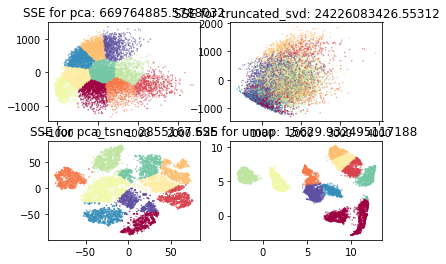

In [14]:
methods = ['pca', 'truncated_svd', 'pca_tsne', 'umap']

for i, method in enumerate(methods):
  x, c, sse= experiment_on_feature_reduction_technique(method=method)
  plt.subplot(2,2,i+1)
  plt.scatter(x[:, 0], x[:, 1], c= c, s=0.1, cmap='Spectral')
  plt.subplot(2,2,i+1).set_title(f'SSE for {method}: {sse}')

plt.show()

Number of iteration took to converge with maximize metric: 19
Sum of Squared Error for the final centroids: 16252.519744873047
Number of iteration took to converge with best_sse metric: 34
Sum of Squared Error for the final centroids: 16094.011901855469
[16252.519744873047, 16094.011901855469]


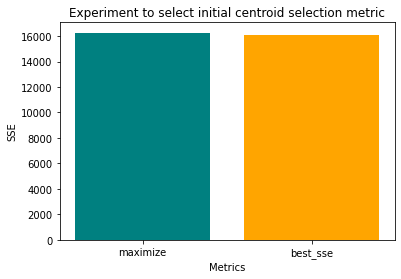

In [12]:
def experiment_to_choose_initial_centroid_method_for_k_means():
    train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668784614_268637_test-data-images.txt'
    train_df = pd.read_csv(train_data_url, header=None, sep=',')
    k = 10
    X = train_df.values
    X = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
    centroid_metrics = ['maximize', 'best_sse']
    sse_score = list()
    for centroid_metric in centroid_metrics:
       clusters, sse = kmeans(X,10, centroid_metric=centroid_metric, dist='euclidian')
       sse_score.append(sse)
    
    print(sse_score)
    plt.bar(centroid_metrics, sse_score,  color = ['teal', 'orange'])
    plt.xlabel("Metrics")
    plt.ylabel("SSE")
    plt.title("Experiment to select initial centroid selection metric")
    plt.show()

experiment_to_choose_initial_centroid_method_for_k_means()

Number of iteration took to converge with best_sse metric: 34
Sum of Squared Error for the final centroids: 16094.011901855469
Number of iteration took to converge with best_sse metric: 64
Sum of Squared Error for the final centroids: 70944.05892944336
Number of iteration took to converge with best_sse metric: 34
Sum of Squared Error for the final centroids: 14695.3212890625
[16094.011901855469, 70944.05892944336, 14695.3212890625]


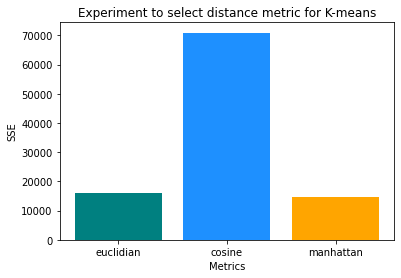

In [13]:
def experiment_to_distance_metric_k_means():
    train_data_url = 'https://raw.githubusercontent.com/ridwant/DataMinig/main/1668784614_268637_test-data-images.txt'
    train_df = pd.read_csv(train_data_url, header=None, sep=',')
    k = 10
    X = train_df.values
    X = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
    distance_metrics = ['euclidian', 'cosine', 'manhattan']
    sse_score = list()
    for distance_metric in distance_metrics:
       clusters, sse = kmeans(X,10, dist=distance_metric)
       sse_score.append(sse)
    
    print(sse_score)
    plt.bar(distance_metrics, sse_score, color= ['teal', 'dodgerblue', 'orange'])
    plt.xlabel("Metrics")
    plt.ylabel("SSE")
    plt.title("Experiment to select distance metric for K-means")
    plt.show()

experiment_to_distance_metric_k_means()